In [ ]:
import os
import zipfile
from urllib.request import urlretrieve
from IPython.display import Image, display

# Define the URL of the zip file
zip_url = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

# Define the directory to extract the contents
extracted_dir = '/content/dataset'  # You can change this directory if needed

# Create the directory if it doesn't exist
os.makedirs(extracted_dir, exist_ok=True)

# Download the zip file
zip_file_path, _ = urlretrieve(zip_url, '/content/dataset/cats_and_dogs_filtered.zip')

# Extract the contents
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

# List the extracted files
extracted_files = os.listdir(extracted_dir)

In [12]:
import os

target_folder = extracted_dir+'/cats_and_dogs_filtered'
train_cat_dir = os.path.join(f'{target_folder}/train/cats')
train_dog_dir = os.path.join(f'{target_folder}/train/dogs')
val_cat_dir = os.path.join(f'{target_folder}/validation/cats')
val_dog_dir = os.path.join(f'{target_folder}/validation/dogs')
train_cat_files = [os.path.join(train_cat_dir, file) for file in os.listdir(train_cat_dir) if
                    os.path.isfile(os.path.join(train_cat_dir, file))]
train_dog_files = [os.path.join(train_dog_dir, file) for file in os.listdir(train_dog_dir) if
                    os.path.isfile(os.path.join(train_dog_dir, file))]
val_cat_files = [os.path.join(val_cat_dir, file) for file in os.listdir(val_cat_dir) if
                  os.path.isfile(os.path.join(val_cat_dir, file))]
val_dog_files = [os.path.join(val_dog_dir, file) for file in os.listdir(val_dog_dir) if
                  os.path.isfile(os.path.join(val_dog_dir, file))]
print(f'total train cat {train_cat_dir} images {len(train_cat_files)}')
print(f'total train dog {train_dog_dir} images {len(train_dog_files)}')
print(f'total val cat {val_cat_dir} images {len(val_cat_files)}')
print(f'total val dog {val_dog_dir} images {len(val_dog_files)}')

total train cat /content/dataset/cats_and_dogs_filtered/train/cats images 1000
total train dog /content/dataset/cats_and_dogs_filtered/train/dogs images 1000
total val cat /content/dataset/cats_and_dogs_filtered/validation/cats images 500
total val dog /content/dataset/cats_and_dogs_filtered/validation/dogs images 500


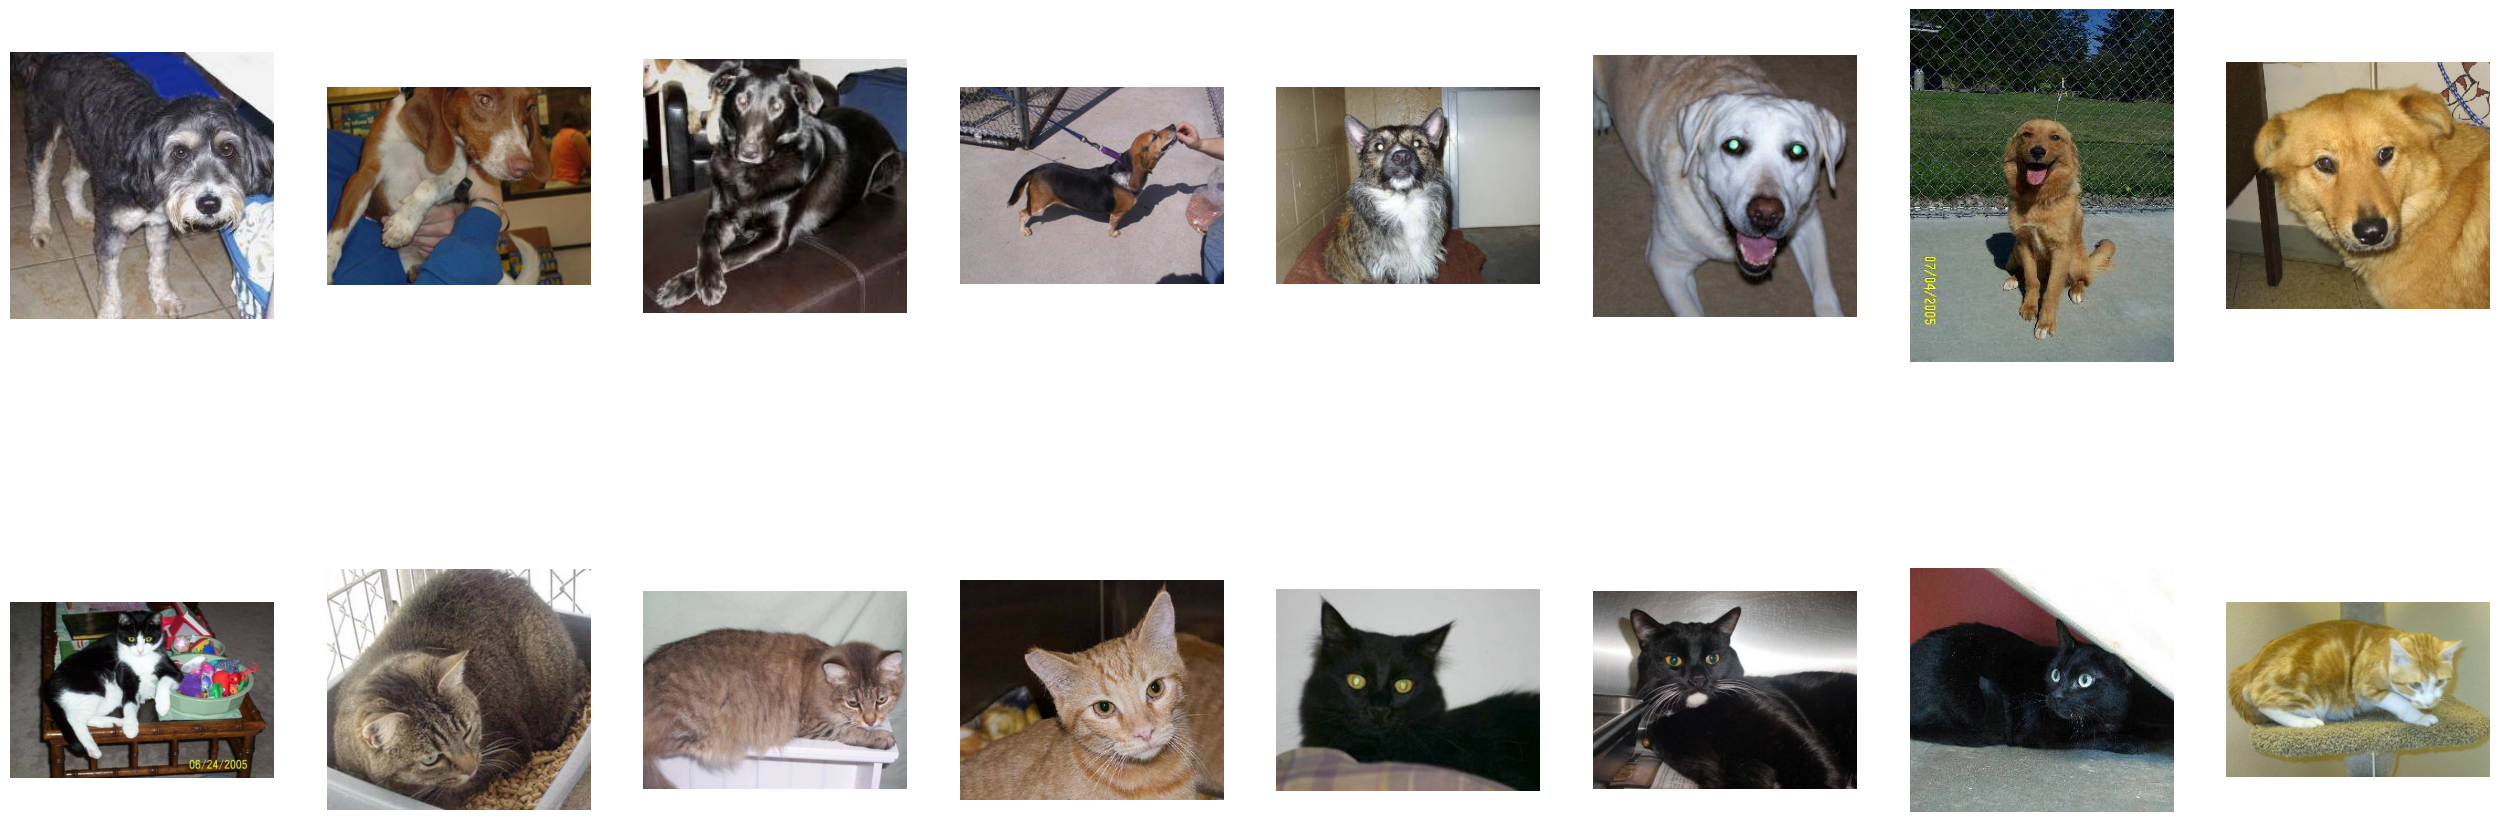

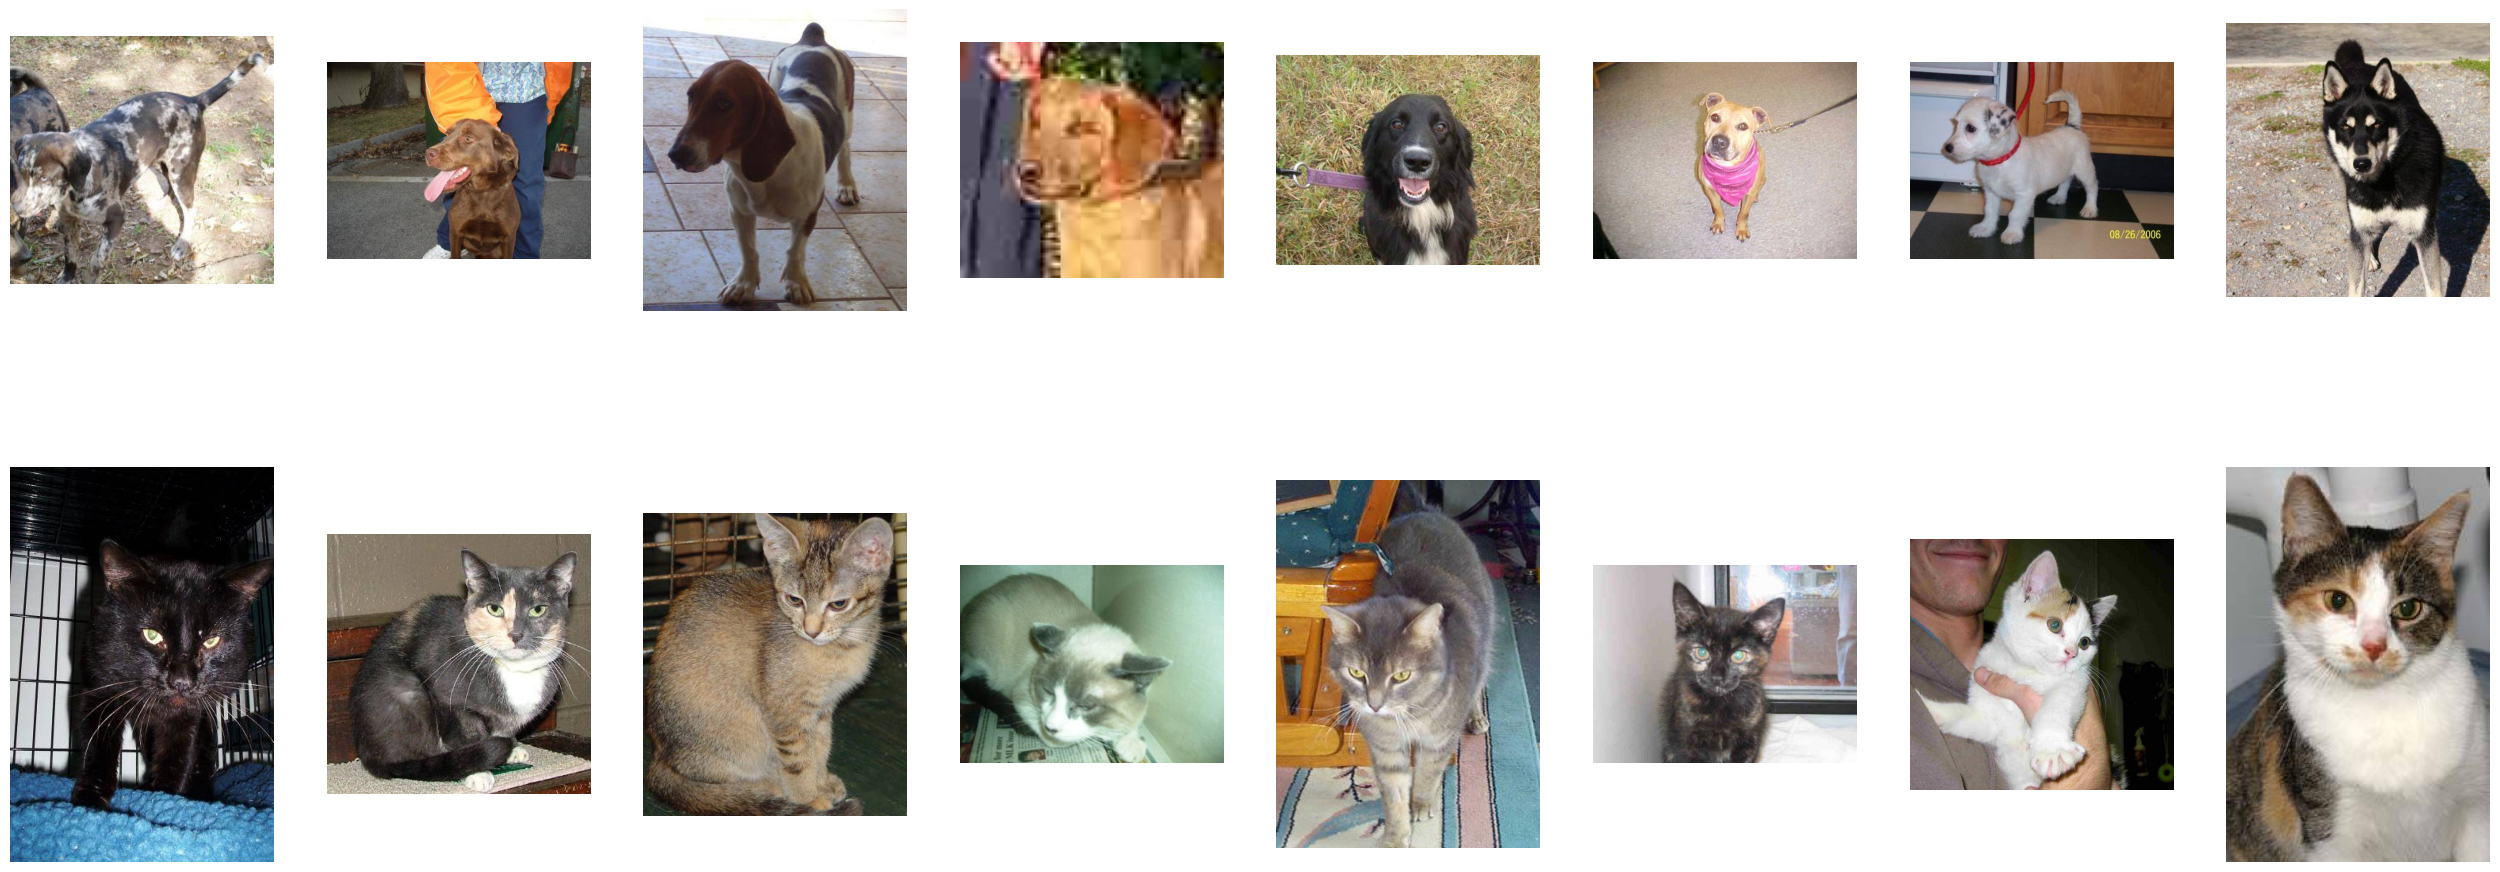

In [13]:
import array
import os
import zipfile

import keras
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import load_img
from keras.src.callbacks import History

def random_display_images(dog_files: array, cat_files: array):
    global f, axs, i
    # list random 8 images for each
    f, axs = plt.subplots(2, 8, figsize=(32, 12))
    for (i, horse_file, human_file) in zip(range(0, 8), np.random.choice(dog_files, size=8),
                                           np.random.choice(cat_files, size=8)):
        axs[0, i].axis('off')
        axs[1, i].axis('off')
        axs[0, i].imshow(matplotlib.image.imread(horse_file))
        axs[1, i].imshow(matplotlib.image.imread(human_file))
    plt.show()

random_display_images(train_dog_files, train_cat_files)
random_display_images(val_dog_files, val_cat_files)

In [20]:
import os

import keras
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

train_img_dir = extracted_dir+'/cats_and_dogs_filtered/train'
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = train_datagen.flow_from_directory(
    train_img_dir,
    target_size=(150, 150),  # all images will be resized to 150*150
    batch_size=20,
    class_mode='binary'  # dog or cat, so binary
)
# validation generator
val_img_dir = extracted_dir+'/cats_and_dogs_filtered/validation'
val_generator = ImageDataGenerator(rescale=1. / 255).flow_from_directory(
    val_img_dir,
    target_size=(150, 150),  # all images will be resized to 150*150
    batch_size=20,
    class_mode='binary'  # dog or cat, so binary
)

# build the model
model = keras.models.Sequential([
    # the first convolution, 150px*150px with 3 bytes color
    keras.layers.Conv2D(16, (3, 3), activation=keras.activations.relu,
                        input_shape=(150, 150, 3)),
    keras.layers.MaxPooling2D(2, 2),
    # the second convolution
    keras.layers.Conv2D(32, (3, 3), activation=keras.activations.relu),
    keras.layers.MaxPooling2D(2, 2),
    # the third convolution
    keras.layers.Conv2D(64, (3, 3), activation=keras.activations.relu),
    keras.layers.MaxPooling2D(2, 2),
    # the forth convolution
    keras.layers.Conv2D(64, (3, 3), activation=keras.activations.relu),
    keras.layers.MaxPooling2D(2, 2),
    # the fifth convolution
    keras.layers.Conv2D(64, (3, 3), activation=keras.activations.relu),
    keras.layers.MaxPooling2D(2, 2),

    keras.layers.Flatten(),
    keras.layers.Dense(512, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)])

print(model.summary())

model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

# train the model
history = model.fit(train_generator, steps_per_epoch=100, epochs=100, verbose=1, validation_data=val_generator,
                    validation_steps=8)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 74, 74, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 36, 36, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_12 (Conv2D)          (None, 34, 34, 64)        18496     
                                    

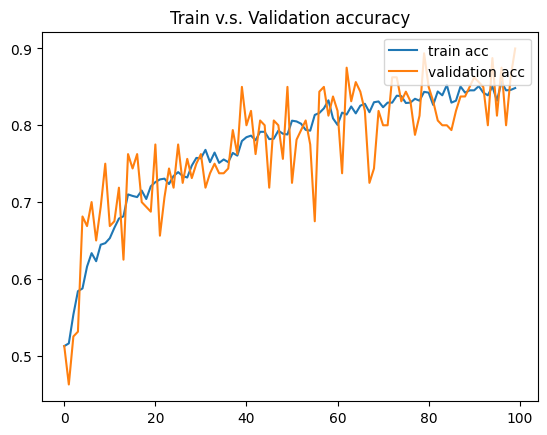

<Figure size 640x480 with 0 Axes>

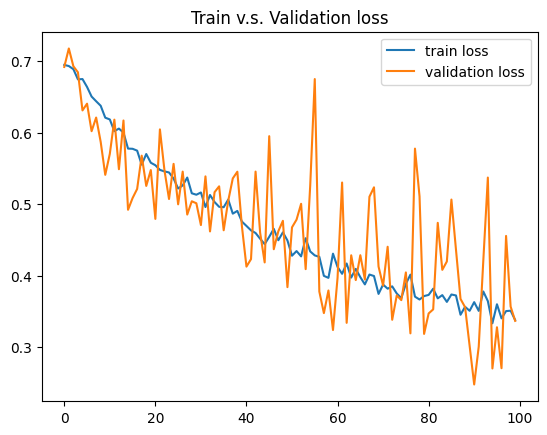

<Figure size 640x480 with 0 Axes>

In [21]:
def show_model_history(history: History):
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    # display the  accuracy
    plt.plot(epochs, acc, label='train acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.title('Train v.s. Validation accuracy')
    plt.legend(loc='upper right')
    plt.figure()
    plt.show()
    # display the  loss
    plt.plot(epochs, loss, label='train loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.title('Train v.s. Validation loss')
    plt.legend(loc='upper right')
    plt.figure()
    plt.show()

show_model_history(model.history)

In [22]:
import numpy as np

from google.colab import files
from keras.preprocessing import image

uploaded=files.upload()
for fn in uploaded.keys():
  # predicting images
  path='/content/'+fn
  img=image.load_img(path,target_size=(150,150))
  x=image.img_to_array(img)
  x /= 255
  x=np.expand_dims(x,axis=0)
  images = np.vstack([x])

  classes = model.predict(images)
  print(classes)
  if classes[0]>0.5:
    print('dog')
  else:
    print('cat')

Saving cat-1.png to cat-1 (1).png
Saving cat-2.png to cat-2 (1).png
Saving cat-3.png to cat-3 (1).png
Saving dog-1.png to dog-1 (1).png
Saving dog-2.png to dog-2 (1).png
Saving dog-3.png to dog-3 (1).png
Saving dog-4.png to dog-4 (1).png
1/1 [==============================] - 0s 88ms/step
[[1.]]
dog
1/1 [==============================] - 0s 18ms/step
[[0.999969]]
dog
1/1 [==============================] - 0s 17ms/step
[[0.91354036]]
dog
1/1 [==============================] - 0s 28ms/step
[[0.9945845]]
dog
1/1 [==============================] - 0s 19ms/step
[[1.]]
dog
1/1 [==============================] - 0s 17ms/step
[[0.8817688]]
dog
1/1 [==============================] - 0s 19ms/step
[[0.00677016]]
cat
